# SUDOKU lösen mit verschiedenen Quanten Computing Ansätzen

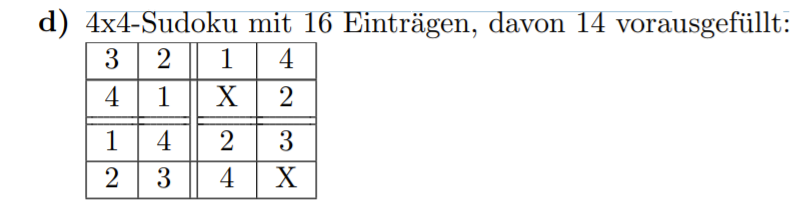

In [25]:
import utils
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## Variablen Deklaration:
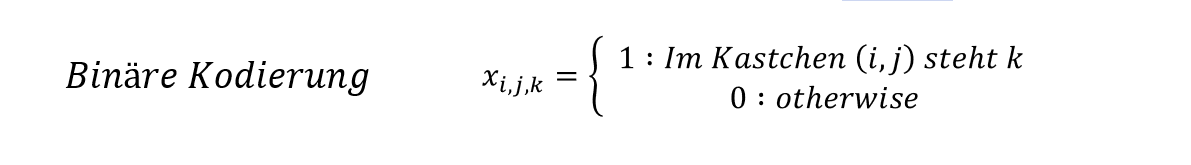

In [26]:
row_num = 4
column_num = 4
k_max = max(row_num, column_num)

num_sub_row = 2
num_sub_column = 2
block_size = 2

In [27]:
#Gewichte für Penalty funktions

alpha = 1
beta = 2
gamma = 2
delta = 1

In [28]:
# known values
known_vars = {}

known_vars[(0,0)] = 2
known_vars[(0,1)] = 1
known_vars[(0,2)] = 0
known_vars[(0,3)] = 3

known_vars[(1,0)] = 3
known_vars[(1,1)] = 0
known_vars[(1,3)] = 1

known_vars[(2,0)] = 0
known_vars[(2,1)] = 3
known_vars[(2,2)] = 1
known_vars[(2,3)] = 2

known_vars[(3,0)] = 1
known_vars[(3,1)] = 2
known_vars[(3,2)] = 3


In [29]:
all_vars = utils.get_all_vars(row_num, column_num, k_max)
var_list = utils.get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = utils.get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [30]:
# prunned variable list
prunned_list = var_list

-------

# Constraints and Penalty functions

In [31]:
n = len(prunned_list)
QUBO = np.zeros((n,n))

### Constraint 1: A single cell can only have one number

$$
\sum_{k=1}^{9} X_{i j k}=1, \quad \forall i j \in \text {cell}
$$

#### Here, we introduce a penalty weight $\alpha$.

$$
\alpha \sum_{i j}\left(\sum_{k=1}^{9} x_{i j k}-1\right)^{2}
$$

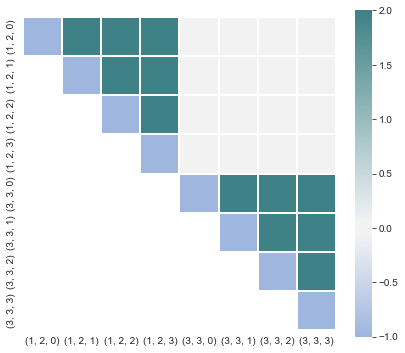

In [32]:
QUBO = utils.h1_penalty(alpha, QUBO, prunned_list)
penalty = 'h1'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 2: Each column j can not have a duplicate number

$$
 \sum_{i} X_{i j k}=1, \quad \forall j \in \text { column }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\beta$.

$$
\beta \sum_{k=1}^{9} \sum_{j}\left(\sum_{i} x_{i j k}-1\right)^{2}
$$

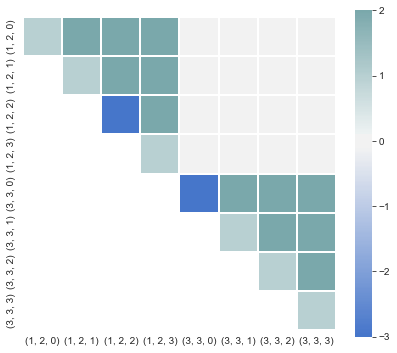

In [33]:
QUBO = utils.h2_penalty(beta, QUBO, prunned_list, all_vars, known_vars)
penalty = 'h2'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 3: Each column row i cannot have any duplicate number

$$
 \sum_{j} X_{i j k}=1, \quad \forall i \in \text { row }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\gamma$.

$$
\gamma \sum_{k=1}^{9} \sum_{i}\left(\sum_{j} x_{i j k}-1\right)^{2}
$$

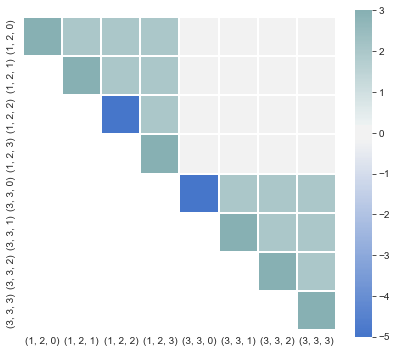

In [34]:
QUBO = utils.h3_penalty(gamma, QUBO, prunned_list, all_vars, known_vars)
penalty = 'h3'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 4: Each of the subgrids cannot have any duplicate number

$$
\sum_{subgrid} x_{ijk}=1, \quad \forall k \in\{1 . .9\} \text{         } 
\forall subgrid 
$$


#### Here, we introduce a penalty weight $\delta$.

$$
\delta \sum_{k=1}^{9}\left(\sum_{subgrid} x_{ijk}-1\right)^{2}
$$

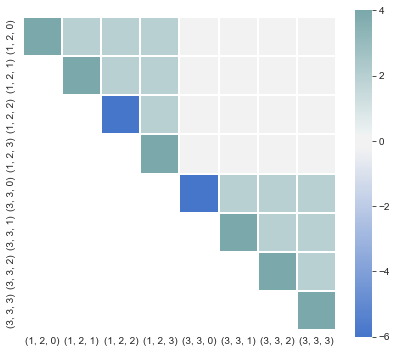

In [35]:
all_blocks = utils.get_all_blocks(num_sub_row, num_sub_column)
QUBO = utils.h4_penalty(delta, QUBO, prunned_list, all_vars, known_vars, block_size, all_blocks)
penalty = 'h4'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

--------

# Lösung mit QBSolve (Simulated Annealing)

In [12]:
qubo_d = utils.matrix_to_dictionary(QUBO)

In [13]:
sampleset = utils.on_QBsolve(qubo_d)
first_sample = sampleset.samples()[0]
result = [y for _, y in first_sample.items()]

In [14]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)

print(solution)

[[2. 1. 0. 3.]
 [3. 0. 2. 1.]
 [0. 3. 1. 2.]
 [1. 2. 3. 0.]]


-----

# Lösung mit DWave (DWave Advantage)

In [38]:
sampleset = utils.on_DWave(QUBO, 1000)
first_sample = sampleset.samples()[0]
result = [y for _, y in first_sample.items()]

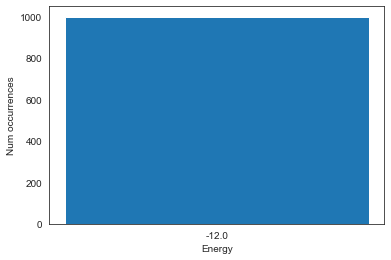

In [39]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
energies = sampleset.record.energy
num_occ = sampleset.record.num_occurrences
y_pos = np.arange(len(energies))

# Create bars
plt.bar(y_pos, num_occ)

# Create names on the x-axis
plt.xticks(y_pos, energies)
plt.xlabel('Energy')
plt.ylabel('Num occurrences')
# Show graphic
#plt.show()
plt.savefig('dwave.jpg')

In [16]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

[[2. 1. 0. 3.]
 [3. 0. 2. 1.]
 [0. 3. 1. 2.]
 [1. 2. 3. 0.]]


----------

# Lösung mit QAOA (Qiskits QuadraticProgram)

In [17]:
quadr_program = utils.QUBO_to_QuadraticProgram(QUBO)
print(quadr_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ 8 x0^2 + 4 x0*x1 + 4 x0*x2 + 4 x0*x3 + 8 x1^2 + 4 x1*x2 + 4 x1*x3
      - 12 x2^2 + 4 x2*x3 + 8 x3^2 - 12 x4^2 + 4 x4*x5 + 4 x4*x6 + 4 x4*x7
      + 8 x5^2 + 4 x5*x6 + 4 x5*x7 + 8 x6^2 + 4 x6*x7 + 8 x7^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= x7 <= 1

Binaries
 x0 x1 x2 x3 x4 x5 x6 x7
End



optimal params:       {ParameterVectorElement(θ[0]): -3.3664404858854833, ParameterVectorElement(θ[1]): 7.055787562440272}
optimal value:        -20.176346295287182


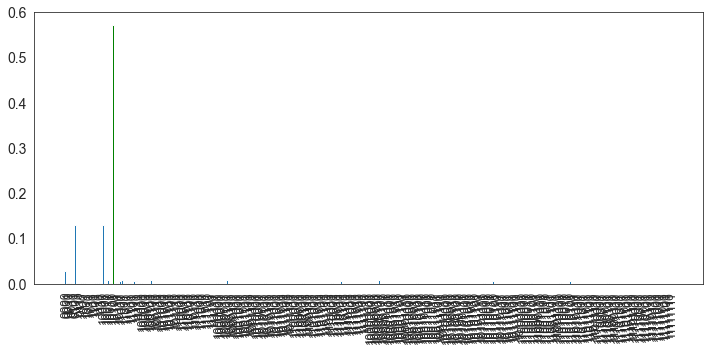

<generator object on_qiskit.<locals>.<genexpr> at 0x0000029024458CF0>


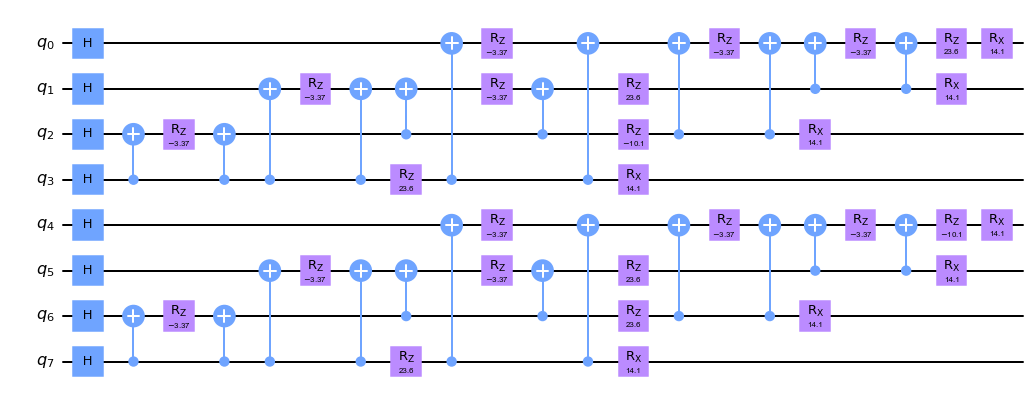

In [40]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

qc = utils.on_qiskit(quadr_program, backend, with_graphic = True)[1]
display(qc.draw('mpl'))

### Kosten:

In [19]:
costs = utils.get_costs(qc)

OrderedDict([('u3', 36), ('cx', 24)])
Cost: 276


In [20]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 19
Gate counts: OrderedDict([('u3', 36), ('cx', 24)])
Optimization Level 1
Depth: 18
Gate counts: OrderedDict([('u3', 34), ('cx', 24)])
Optimization Level 2
Depth: 18
Gate counts: OrderedDict([('u3', 34), ('cx', 24)])
Optimization Level 3
Depth: 18
Gate counts: OrderedDict([('u3', 34), ('cx', 24)])


In [21]:
utils.get_costs(trans_qc)

OrderedDict([('u3', 34), ('cx', 24)])
Cost: 274


274

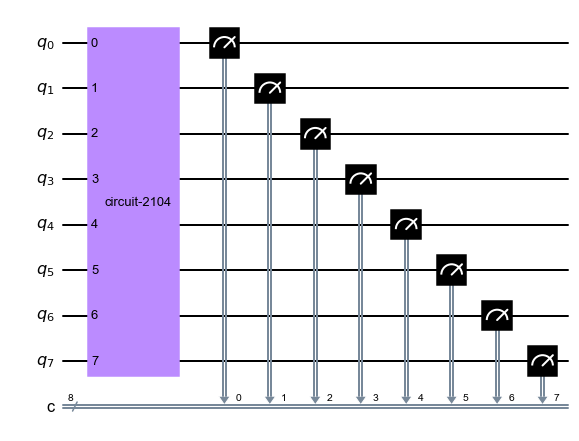

In [22]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
counts = utils.measure_ciruit(qc, backend, shots = 1000)
result = counts.most_frequent()

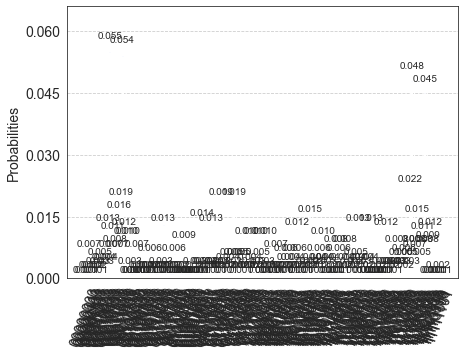

In [23]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [24]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

[[2. 1. 0. 3.]
 [3. 0. 3. 1.]
 [0. 3. 1. 2.]
 [1. 2. 3. 1.]]
